In [610]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import xgboost as xgb

In [611]:
#Dataset has 'NaN' values , hence dropping them
ufodata = pd.read_csv('ufodata.csv',delimiter=',').dropna().values

In [612]:
#Find shape. Note that last column is the label
ufodata.shape

(17998, 15)

In [613]:
ufodata_features, ufodata_labels = ufodata[:,:14],ufodata[:,14]

In [614]:
## Convert labels to numeric
#Start with mapping label text to a number
label_map = {}
count = 0
for ot in np.unique(ufodata_labels):
    label_map[ot] = count
    count += 1

#Update ufodata_labels to the numbers
ufodata_labels = np.array([label_map[item]  for item in ufodata_labels])

### Approach # 1:

#### Use One-Hot-encoding to create new columns to be in place of those columns containing string categorical data

In [618]:
#Filter to columns we are interested in the ufodata_features
df = pd.DataFrame(ufodata_features)
ufo_features_df = df[[3,4,5,6,9,10,12,13]]
ufo_features_df

,3,4,5,6,9,10,12,13
0,circle,4,1,rain,47.3294,-122.579,N,N
1,disk,4,1,partly cloudy,52.6649,-1.03489,Y,N
2,circle,49,1,clear,38.9517,-92.3339,N,N
3,disk,13,1,partly cloudy,41.4969,-71.3678,N,N
4,circle,17,1,mostly cloudy,47.6064,-122.331,N,N
...,...,...,...,...,...,...,...,...
17993,square,95,10,snow,42.0333,-87.7333,N,N
17994,circle,55,10,stormy,43.0044,-71.3489,N,N
17995,circle,39,10,partly cloudy,36.8664,-83.8889,N,N
17996,square,28,10,snow,35.3858,-94.3983,N,N


#### Since most of the columns are text , will need to encode them to a numeric value. Since the number of categories in each are relatively low, will attempt to try this as One-hot encoding

#### Next, will need to pick out each of the string columns and have them one-hot-encoded, which will result in several columns that we have to insert back into the ufo_features_df dataframe and remove the original string column. Since we have several columns, will achieve this through a loop

##### Note: The reshape(-1,1) is being done to achieve the operation of converting the 1-D array to a 2-D array

##### From: 

`
array(['triangle', 'light', 'disk', ..., 'square', 'circle', 'square'],
      dtype=object)
`
##### To: 
`
array([['triangle'],
       ['light'],
       ['disk'],
       ...,
       ['square'],
       ['circle'],
       ['square']], dtype=object)
`

#### 3,6,11,12,13 are the columns which need to be worked on

In [619]:
# Loop over all the text columns, One-Hot-Encode them , add them into the main features dataframe and then remove text columns
cols = ufo_features_df[[3,6,12,13]].columns
for i in cols:
    # Initialize a One hot encoder object
    ohe = OneHotEncoder();
    # Run the ohe function to transform each column (i.e 'i') and get data returned as an array of arrays
    encodedColumns = ohe.fit_transform(ufo_features_df[i].values.reshape(-1,1)).toarray()
    # Insert columns generated into parent DF
    dfOneHotEnc = pd.DataFrame(encodedColumns,columns = ["Col_{}_{}".format(i,j) for j in range(encodedColumns.shape[1])])
    # Add the one hot encoded rows into the train features dataframe
    ufo_features_df = pd.concat([ufo_features_df,dfOneHotEnc],axis=1)
    # Dropping the text column 
    ufo_features_df = ufo_features_df.drop([i],axis=1)
    
#Display the finalized dataframe that has been One-Hot-Encoded
ufo_features_df

,4,5,9,10,Col_3_0,Col_3_1,Col_3_2,Col_3_3,Col_3_4,Col_3_5,...,Col_6_1,Col_6_2,Col_6_3,Col_6_4,Col_6_5,Col_6_6,Col_12_0,Col_12_1,Col_13_0,Col_13_1
0,4,1,47.3294,-122.579,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,4,1,52.6649,-1.03489,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,49,1,38.9517,-92.3339,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,13,1,41.4969,-71.3678,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,17,1,47.6064,-122.331,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17993,95,10,42.0333,-87.7333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
17994,55,10,43.0044,-71.3489,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
17995,39,10,36.8664,-83.8889,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
17996,28,10,35.3858,-94.3983,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [620]:
# Cast back values as the ufodata_features array.
ufodata_features_ohe = ufo_features_df.values

In [621]:
#Split the dataset 85% to 15%
np.random.seed(0)
train_features,test_features,train_labels,test_labels = train_test_split(ufodata_features_ohe,ufodata_labels,test_size=0.20)

In [622]:
#Confirmation of split of data between Train and Test
totaldata= train_features.shape[0]+test_features.shape[0]
datasetsplit = (train_features.shape[0]/totaldata,test_features.shape[0]/totaldata)
datasetsplit

(0.7999777753083676, 0.20002222469163242)

In [623]:
#reverse the dictionary items in label_map to use in the label_counts to plot
reverse_label_map = {v:k for k,v in label_map.items()}

<AxesSubplot:title={'center':'Label Counts'}>

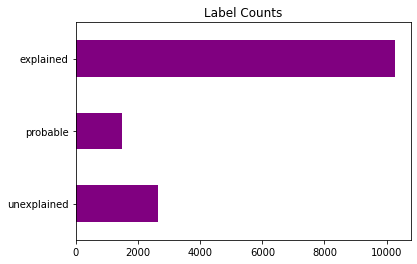

In [624]:
label_counts = pd.DataFrame(data=train_labels)[0].map(reverse_label_map).value_counts(sort=False).sort_index(ascending=False)
label_counts.plot(kind='barh', color='purple', title='Label Counts')

In [625]:
%%time
#Train the model using 'One vs rest' classifier
lm_ohe = linear_model.LogisticRegressionCV(cv=5,multi_class='ovr', solver='liblinear')
lm_ohe.fit(train_features, train_labels)

Wall time: 5.61 s


LogisticRegressionCV(cv=5, multi_class='ovr', solver='liblinear')

In [626]:
# Test on a random test row. In this example the 1000th row was chosen
print('Predicted value is : {}'.format(lm_ohe.predict([test_features[1000,:]])[0]))
print('Actual value is : {}'.format(test_labels[1000]))

Predicted value is : 1
Actual value is : 1


In [627]:
#Calculate percentage of accurate predictions on test set
accuracy = lm_ohe.score(test_features,test_labels)
print("Accuracy is : {} %".format(accuracy*100))

Accuracy is : 94.44444444444444 %


In [628]:
print(metrics.classification_report(test_labels, lm_ohe.predict(test_features)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2562
           1       0.80      0.91      0.85       375
           2       0.91      0.91      0.91       663

    accuracy                           0.94      3600
   macro avg       0.90      0.93      0.91      3600
weighted avg       0.95      0.94      0.95      3600



In [585]:
def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]

    # parse protobuf responses to extract predicted labels
    test_preds = np.concatenate([np.array([x for x in batch]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    
    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(reverse_label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: reverse_label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.944


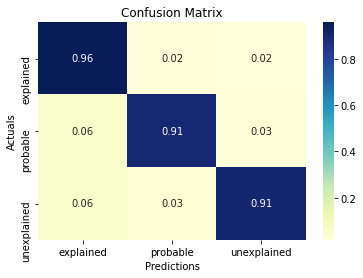

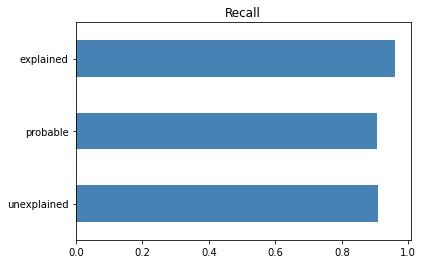

In [629]:
#Metrics of sklearn linear regression using ohe
evaluate_metrics(lm_ohe, test_features, test_labels)

In [630]:
xgb_ohe = xgb.XGBClassifier(objective="multi:softprob", random_state=42, eval_metric="auc")
xgb_ohe.fit(train_features,train_labels)

predicted_labels = xgb_ohe.predict(test_features)

metrics.accuracy_score(test_labels,predicted_labels)


c:\python38\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9386111111111111

In [631]:
# Test on a random test row. In this example the 1000th row was chosen
print('Predicted value is : {}'.format(xgb_ohe.predict(test_features)[1000]))
print('Actual value is : {}'.format(test_labels[1000]))

Predicted value is : 1
Actual value is : 1


In [632]:
#Calculate percentage of accurate predictions on test set
accuracy = xgb_ohe.score(test_features,test_labels)
print("Accuracy is : {} %".format(accuracy*100))

Accuracy is : 93.8611111111111 %


In [633]:
print(metrics.classification_report(test_labels, xgb_ohe.predict(test_features)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2562
           1       0.83      0.85      0.84       375
           2       0.91      0.89      0.90       663

    accuracy                           0.94      3600
   macro avg       0.90      0.90      0.90      3600
weighted avg       0.94      0.94      0.94      3600



Accuracy: 0.939


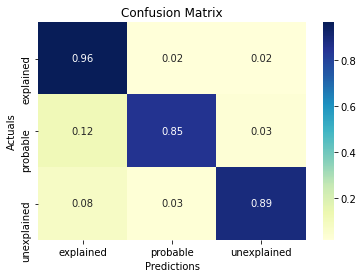

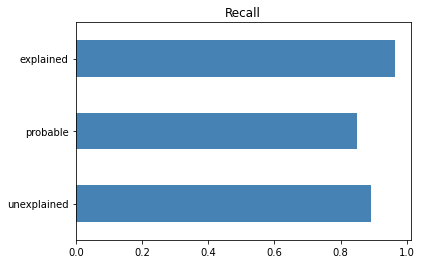

In [634]:
#Metrics of sklearn linear regression using ohe
evaluate_metrics(xgb_ohe, test_features, test_labels)

### Approach # 2:

#### Use Label-encoding on string based features

In [635]:
#Filter to columns we are interested in the ufodata_features
df = pd.DataFrame(ufodata_features)
ufo_features_df = df.loc[:, [3,4,5,6,9,10,12,13]]
ufo_features_df

,3,4,5,6,9,10,12,13
0,circle,4,1,rain,47.3294,-122.579,N,N
1,disk,4,1,partly cloudy,52.6649,-1.03489,Y,N
2,circle,49,1,clear,38.9517,-92.3339,N,N
3,disk,13,1,partly cloudy,41.4969,-71.3678,N,N
4,circle,17,1,mostly cloudy,47.6064,-122.331,N,N
...,...,...,...,...,...,...,...,...
17993,square,95,10,snow,42.0333,-87.7333,N,N
17994,circle,55,10,stormy,43.0044,-71.3489,N,N
17995,circle,39,10,partly cloudy,36.8664,-83.8889,N,N
17996,square,28,10,snow,35.3858,-94.3983,N,N


In [637]:
# Loop over all the text columns, label encode them and replace in place
cols = ufo_features_df[[3,6,12,13]].columns
for i in cols:
    lblEnc = LabelEncoder();
    ufo_features_df.loc[:,i] = lblEnc.fit_transform(ufo_features_df.loc[:,i])
#Display the finalized dataframe that has been One-Hot-Encoded
ufo_features_df

,3,4,5,6,9,10,12,13
0,1,4,1,4,47.3294,-122.579,0,0
1,2,4,1,3,52.6649,-1.03489,1,0
2,1,49,1,0,38.9517,-92.3339,0,0
3,2,13,1,3,41.4969,-71.3678,0,0
4,1,17,1,2,47.6064,-122.331,0,0
...,...,...,...,...,...,...,...,...
17993,7,95,10,5,42.0333,-87.7333,0,0
17994,1,55,10,6,43.0044,-71.3489,0,0
17995,1,39,10,3,36.8664,-83.8889,0,0
17996,7,28,10,5,35.3858,-94.3983,0,0


In [638]:
# Cast back values as the ufodata_features array.
ufodata_features_lblEnc = ufo_features_df.values

In [639]:
#Split the dataset 85% to 15%
np.random.seed(0)
train_features,test_features,train_labels,test_labels = train_test_split(ufodata_features_lblEnc,ufodata_labels,test_size=0.15)

In [640]:
#Confirmation of split of data between Train and Test
totaldata= train_features.shape[0]+test_features.shape[0]
datasetsplit = (train_features.shape[0]/totaldata,test_features.shape[0]/totaldata)
datasetsplit

(0.8499833314812757, 0.1500166685187243)

In [641]:
#reverse the dictionary items in label_map to use in the label_counts to plot
reverse_label_map = {v:k for k,v in label_map.items()}

<AxesSubplot:title={'center':'Label Counts'}>

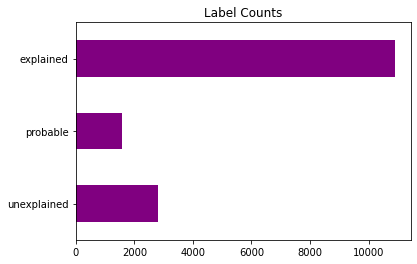

In [642]:
label_counts = pd.DataFrame(data=train_labels)[0].map(reverse_label_map).value_counts(sort=False).sort_index(ascending=False)
label_counts.plot(kind='barh', color='purple', title='Label Counts')

In [643]:
%%time
#Train the model using 'One vs rest' classifier
lm_lblEnc = linear_model.LogisticRegressionCV(cv=5,multi_class='ovr', solver='liblinear')
lm_lblEnc.fit(train_features, train_labels)

Wall time: 7.05 s


LogisticRegressionCV(cv=5, multi_class='ovr', solver='liblinear')

In [644]:
# Test on a random test row. In this example the 1000th row was chosen
print('Predicted value is : {}'.format(lm_lblEnc.predict([test_features[1000,:]])[0]))
print('Actual value is : {}'.format(test_labels[1000]))

Predicted value is : 1
Actual value is : 1


In [645]:
#Calculate percentage of accurate predictions on test set
accuracy = lm_lblEnc.score(test_features,test_labels)
print("Accuracy is : {} %".format(accuracy*100))

Accuracy is : 80.11111111111111 %


In [646]:
print(metrics.classification_report(test_labels, lm_lblEnc.predict(test_features)))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1927
           1       0.59      0.37      0.46       281
           2       0.49      0.42      0.45       492

    accuracy                           0.80      2700
   macro avg       0.65      0.58      0.61      2700
weighted avg       0.78      0.80      0.79      2700



Accuracy: 0.801


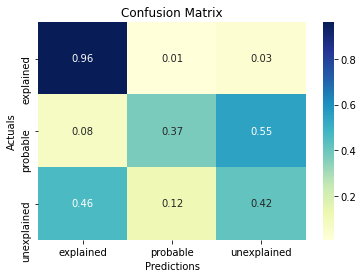

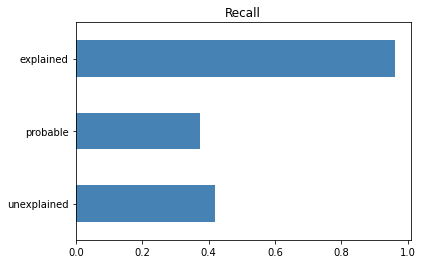

In [647]:
evaluate_metrics(lm_lblEnc, test_features, test_labels)

In [656]:
xgb_lblEnc = xgb.XGBClassifier(objective="multi:softmax", num_class = 3, num_round=300, eval_metric = "error")
xgb_lblEnc.fit(train_features,train_labels)

predicted_labels = xgb_lblEnc.predict(test_features)

metrics.accuracy_score(test_labels,predicted_labels)


[20:33:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.942962962962963

In [649]:
# Test on a random test row. In this example the 1000th row was chosen
print('Predicted value is : {}'.format(xgb_lblEnc.predict(test_features)[1000]))
print('Actual value is : {}'.format(test_labels[1000]))

Predicted value is : 1
Actual value is : 1


In [650]:
#Calculate percentage of accurate predictions on test set
accuracy = xgb_lblEnc.score(test_features,test_labels)
print("Accuracy is : {} %".format(accuracy*100))

Accuracy is : 94.2962962962963 %


In [651]:
print(metrics.classification_report(test_labels, xgb_lblEnc.predict(test_features)))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1927
           1       0.84      0.86      0.85       281
           2       0.91      0.91      0.91       492

    accuracy                           0.94      2700
   macro avg       0.90      0.91      0.91      2700
weighted avg       0.94      0.94      0.94      2700



Accuracy: 0.938


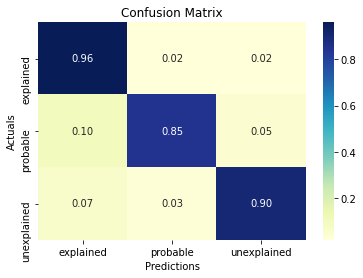

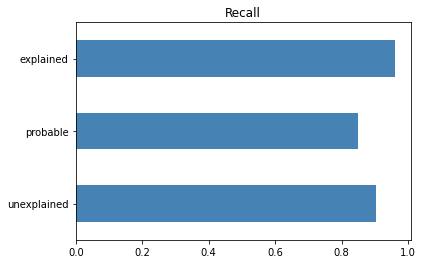

In [608]:
#Metrics of sklearn linear regression using ohe
evaluate_metrics(xgb_lblEnc, test_features, test_labels)